In [1]:
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

# ベータ分布
まず確率密度関数としてベータ分布を考える。ベータ分布の確率密度関数は、
$$
\begin{align}
p(x|\alpha, \beta) = \frac{x^{\alpha -1} (1-x)^{\beta - 1} }{ B(\alpha,\beta)}\\
0 \leq x \leq 1, \alpha > 0, \beta > 0 \\
B(\alpha, \beta ) = \int_0^1 x^{\alpha -1 } (1-x)^{\beta-1} dx
\end{align}
$$
である。いろいろな$\alpha, \beta$にたいして確率密度関数(PDF: Possibility Distribution Function)をプロットすると以下の通り。


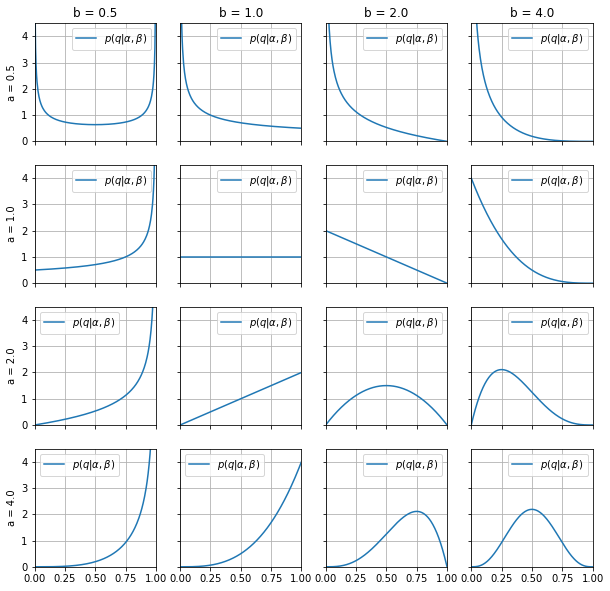

In [2]:
q = np.linspace(0, 1, 250)
value_a = np.array([0.5, 1.0, 2.0, 4.0])
value_b = np.array([0.5, 1.0, 2.0, 4.0])
rows = value_a.shape[0]
cols = value_b.shape[0]
fig, ax = plt.subplots(rows, cols, figsize=(10, 10), sharex='all', sharey='all')

ax[0,0].set_xlim(0, 1)
ax[0,0].set_ylim(0, 4.5)

for row_index in range(rows):
    a = value_a[row_index]
    ax[row_index, 0].set_ylabel('a = {}'.format(a))
    for col_index in range(cols):
        b = value_b[col_index]
        ax[row_index, col_index].plot(q, st.beta.pdf(q, a, b), label=r'$p(q|\alpha, \beta)$')
        ax[row_index, col_index].legend()
        ax[row_index, col_index].grid()
        if row_index==0:
            ax[0, col_index].set_title('b = {}'.format(b))
            

横軸$q$は運よく内閣支持者を引き当てることができる確率、成功確率である。

# ベイズの定理
成功確率$q$と、データ$D={x_1, ..., x_n}$の組み合わせが同時に実現する確率$p(q, D)$について、
$$
p(q, D) = p(q|D) p(D) = p(D|q) p(q)
$$
であるから、
$$
p(q|D) = \frac{p(D|q)p(q)}{p(D)}
$$
である。これがベイズの定理である。

右辺の分子$p(D|q)$は、「仮に成功確率が$q$であったときにデータ$D$が実際に観測される確率」であり、$D$を生成した確率分布そのものである。
$D$の各要素はベルヌーイ分布
$$
\begin{align}
p(x_i) &= q^{x_i} (1-q)^{1-x_i} \\
(x_i &= \{ 0, 1\})
\end{align}
$$
で与えられるので、
$$
\begin{align}
p(D|q) &= \prod_{i=1}^{n} q_i (1-q)^{1-x_i} = q^y (1-q)^{n-y} \\
(y &= \sum_{i=1}^{n} x_i)
\end{align}
$$

また分母$p(D)$を見ると
$$
p(D) = \int_0^1 p(D, q) dq = \int_0^1 p(D|q) p(q) dq
$$
と書けるので、$p(D)$は「事前分布を$p(q)$を仮定したときの、データ$D$が観測される平均的な可能性」と解釈することができる。

以上を踏まえると、ベイズの定理は、
「事前分布$p(q)$に対して、データによる更新のファクター$\frac{p(D|q)}{p(D)}$を掛けて、事後分布$p(q|D)$を得る。」
のように解釈することができる。

$p(D)$はデータが観測された後では固定されてしまうので、ベイズの定理を比例式として
$$
p(q|D) \propto p(D|q) p(q)
$$
のように書くことができる。



今回、事前分布として$\alpha=\alpha_0, \beta=\beta_0$のベータ分布を与えるとすると、
$$
\begin{align}
p(q|D) \propto p(D|q) p(q) 
&\propto q^y (1-q)^{n-y} \times \frac{q^{\alpha_0 - 1} (1-q)^{\beta_0 -1}}{B(\alpha_0, \beta_0)} \\
&\propto q^{y+\alpha_0-1} (1-q)^{n-y+\beta_0-1}
\end{align}
$$

規格化定数も含めれば
$$
\begin{align}
&p(q|D) = \frac{q^{\alpha_*-1} (1-q)^{\beta_*-1}}{B(\alpha_*, \beta_*)}, \\
&\alpha_* = y + \alpha_0, \\
&\beta_* = n - y + \beta_0 \\
\end{align}
$$

# See Bayes theory in beta distribution

beta分布に対するHPD Interval (Highest Posterior Density区間)を得る関数と、統計量をまとめる関数を定義する。

In [16]:
def beta_hpdi(ci0, alpha, beta, prob):
    """
    Input:
        ci0: initial value of HPD interval
        alpha: parameter of beta distribution
        beta: prameter of beta distribution
        prob: probability of HPD interval (0<prob<1)
    """
    def hpdi_conditions(v, a, b, p):
        """
        Input:
            v: HPD interval
            a: parameter of beta distribution
            b: prameter of beta distribution
            p: probability of HPD interval (0<p<1)
        """
        eq1 = st.beta.cdf(v[1], a, b) - st.beta.cdf(v[0], a, b) - p
        eq2 = st.beta.pdf(v[1], a, b) - st.beta.pdf(v[0], a, b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x
        

def bernoulli_stats(data, a0, b0, prob):
    """
    Inuput:
        data: data (0 or 1)
        a0: alpha of prior
        b0: beta of prior
        prob: credible interval
    Returns:
        resutlts: pandas dataframe
        a: alpha of posterior
        b: beta of posterior
    """
    n = data.size
    sum_data = np.sum(data)
    a = sum_data + a0         #### alpha of posterior
    b = n - sum_data + b0     #### beta of posterior
    mean_pi = st.beta.mean(a, b)
    median_pi = st.beta.median(a, b)
    mode_pi = (a - 1) / (a + b - 2)
    sd_pi = st.beta.std(a, b)
    ci_pi = st.beta.interval(prob, a, b)
    hpdi_pi = beta_hpdi(ci_pi, a, b, prob)

    stats = np.hstack((mean_pi, median_pi, mode_pi, sd_pi, ci_pi, hpdi_pi))
    stats = stats.reshape((1, 8))
    stats_string = ['mean', 'median', 'mode', 'sd', 'CI (lower)', 'CI (upper)', 'HPDI (lower)', 'HPDI (upper)']
    
    param_string = ['possibility of success (q)']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, a, b

実際にデータを生成する。
* n=50
* p=0.25

とする。

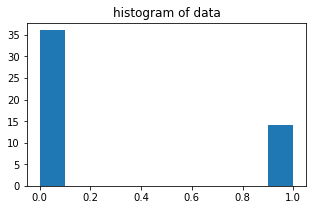

In [6]:
# generate data
p = 0.25
n = 50
np.random.seed(99)
data = st.bernoulli.rvs(p, size=n)

#plot histogram
plt.figure(figsize=(5, 3))
plt.hist(data)
plt.title('histogram of data')
plt.show()


## 解析
priorとして$\alpha_0=1$, $\beta_0=1$のベータ分布すなわち、一様分布を仮定する。

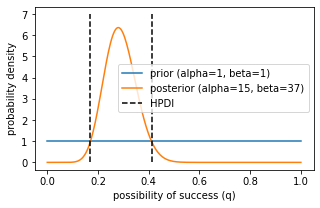

In [17]:
# calculate stats
a0 = 1 # uniform prior
b0 = 1 # uniform prior
prob = 0.95 # credible interval

# analyze data
results, a, b = bernoulli_stats(data, a0, b0, prob) 

# plot probability density functions
fig1 = plt.figure(figsize=(5, 3))
q = np.linspace(0, 1, 250)
plt.plot(q, st.beta.pdf(q, a0, b0), label=f'prior (alpha={a0}, beta={b0})')
plt.plot(q, st.beta.pdf(q, a, b), label=f'posterior (alpha={a}, beta={b})')
plt.vlines([results.loc['possibility of success (q)', 'HPDI (lower)'], 
            results.loc['possibility of success (q)', 'HPDI (upper)']],
             0, 7, colors='k', linestyles='dashed', label='HPDI')


plt.xlabel('possibility of success (q)')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [15]:
results

,mean,median,mode,sd,CI (lower),CI (upper),HPDI (lower),HPDI (upper)
possibliity of success (q),0.288462,0.285732,0.28,0.062231,0.17488,0.417448,0.169919,0.411528


## 事前分布依存性の可視化。

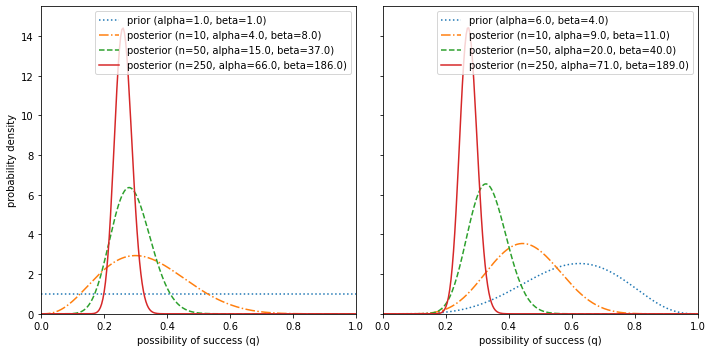

In [19]:
# plot several prior distributions
np.random.seed(99)
n_max = 250
data = st.bernoulli.rvs(p, size=n_max)
value_size = np.array([10, 50, 250])
value_a0 = np.array([1.0, 6.0])
value_b0 = np.array([1.0, 4.0])
styles = [':', '-.', '--', '-']

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey='all')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 15.5)
ax[0].set_ylabel('probability density')
for i, (a0_i, b0_i) in enumerate(zip(value_a0, value_b0)):
    style_idx = 0
    ax[i].plot(q, st.beta.pdf(q, a0_i, b0_i),
                label=f'prior (alpha={a0_i}, beta={b0_i})',
                linestyle=styles[style_idx])
    for n_j in value_size:
        style_idx += 1
        sum_data = np.sum(data[:n_j])
        a_j = sum_data + a0_i
        b_j = n_j - sum_data + b0_i
        ax[i].plot(q, st.beta.pdf(q, a_j, b_j), 
                    label=f'posterior (n={n_j}, alpha={a_j}, beta={b_j})',
                     linestyle=styles[style_idx])
    ax[i].set_xlabel('possibility of success (q)')
    ax[i].legend()
fig.tight_layout()
plt.show()





データ数が十分大きければ事後分布は事前分布によらないことが分かる。

# 仮説検証
次のような仮説を考える。
$$
H_0: q \geq 0.4
$$
すなわち「内閣支持率が50%以上である」という仮説である。

まずは単純に
$$
\rm{Pr}\{ q \geq 0.5 | D\} = 1 - \int_{0}^{0.4} p(q|D)dq
$$
を求めると、

In [21]:
1.0 - st.beta.cdf(0.4, a, b)

0.043568366759263344

4%程度となり、可能性が低いことが推測される。

# Bayes Factor
より詳細な検証としてベイズファクターを考える。まず以下のような対立する二つの仮説を考える。
$$
\begin{align}
H_0: q \in S_0 \\
H_1: q \in S_i
\end{align}
$$

ここで$S_0, S_1$は、
* 二つの仮説が同時に成り立つことはなく
* 必ずどちらかが成立する

ものとする。すなわち$S_0 \cap S_1 = \emptyset$, $S_0 \cup S_1 = [0, 1]$。

このときベイズファクター$B_{0,1}$は、
$$
B_{0,1} = 
\frac{\rm{Pr} \{H_0 | D\}}
{\rm{Pr} \{H_1 | D\}}
\times
\frac{\rm{Pr} \{ H_0 \}}
{\rm{Pr} \{ H_1 \}}
$$

とかける。ここで
$$
\begin{align}
\frac{\rm{Pr} \{H_0 | D\}}
{\rm{Pr} \{H_1 | D\}}
&=
\rm{posterior\ odds} \\
\frac{\rm{Pr} \{ H_0 \}}
{\rm{Pr} \{ H_1 \}}
&=
\rm{prior\ odds}
\end{align}
$$
であり、posterior oddsをprior oddで割ることによって、priorによる仮説の有利不利を是正している。


In [24]:
posterior_odds = (1.0 - st.beta.cdf(0.4, a, b)) / st.beta.cdf(0.4, a, b)
prior_odds = (1.0 - st.beta.cdf(0.4, a0, b0)) / st.beta.cdf(0.4, a0, b0)
print(f'prior odds: {prior_odds:.2f}')
print(f'posterior odds: {posterior_odds:.2f}')
print(f'bayes factor: {posterior_odds / prior_odds:.2f}')
print(f'log(bayes factor): {np.log10(posterior_odds / prior_odds):.2f}')

prior odds: 1.50
posterior odds: 0.05
bayes factor: 0.03
log(bayes factor): -1.52


表に照らし合わせると、等級3「$H_1$に対する支持は強い」に該当し、内閣支持率が40%以下である可能性が高い。

# SDDR (Savage-Dickey Density Ratio)
パラメータの真の値が等しいか等しくないかの検定のために用いられるベイズファクターをSDDRと呼ぶ。
すなわち二つの仮説
$$
\begin{align}
H_0: q = q_0 \\
H_1: q \neq q_0
\end{align}
$$
を検証したい。

このときにはpriorとして
$$
p(q) = p_0 \delta (q-q_0) + (1-p_0) f(q)
$$
を考える。$f(q)$は連続的な確率密度関数、$p_0$は$H_0$が正しい($q=q_0$となる)確率である。
これによってオッズが0に収束してしまうことを回避できる。

このときのベイズファクターは、
$$
\begin{align}
B_{01} = \frac{f(q_0|D)}{f(q_0)} \\
f(q|D) = \frac{p(D|q) f(q)}{\int_0^1 p(D|q) f(q) dq}
\end{align}
$$
と書ける。これをSDDRと呼ぶ。

実際に
$$
\begin{align}
H_0: q = 0.5 \\
H_1: q \neq 0.5
\end{align}
$$
を検証する。

In [25]:
print(f'log(SDDR): {np.log10(st.beta.pdf(0.5, a, b) / st.beta.pdf(0.5, a0, b0)):.2f}')

log(SDDR): -1.37


したがって$H_0$は強く否定されるといえる。